In [371]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import datetime
%matplotlib inline

In [400]:
# day of the year 
#(note that winter = 1:78, spring = 79:171, summer =172:265, fall =266:355, winter =356:365)

day = 360

b=(day*48)
a= b-48


print(a)
print(b)

17232
17280


Total generation for the day : 5.03 MWh
Annual Solar Generation: 27948.65 MWh


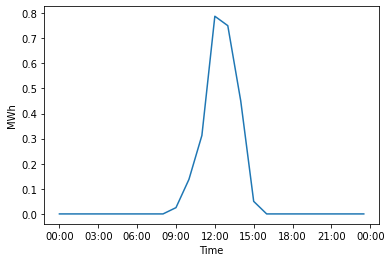

In [401]:
# import data
solar_profile = pd.read_csv("../new data/Solar-half-hourly-power.csv", usecols=[1])
solar_profile.Power = solar_profile.Power*0.5 #convert power to energy

# plot data

plt.plot(solar_profile[a:b]) # just plotting a single day from the entire year
plt.ylabel("MWh")
plt.xlabel("Time")
plt.xticks(np.linspace(a, b, 9),['00:00','03:00','06:00','09:00','12:00','15:00','18:00','21:00','00:00'])
plt.show

#calculate demand for that specific day
print("Total generation for the day : {:.2f} MWh".format(solar_profile.Power[a:b].sum()))

# calculate annual generation
print("Annual Solar Generation: {:.2f} MWh".format(solar_profile.Power.sum()))

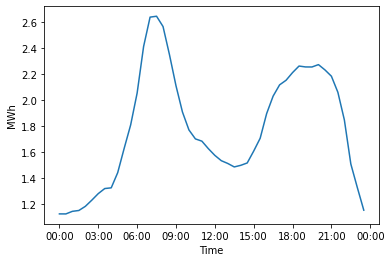

Total demand for the day : 85.48 MWh
Annual Demand : 23463.88 MWh


In [410]:
# import data
load_profile = pd.read_csv("../new data/demand(noEV).csv", usecols=[1])
load_profile.Power = load_profile.Power *0.5 #convert power to energy

# plot data
plt.plot(load_profile[a:b]) # just plotting a single day from the entire year
plt.ylabel("MWh")
plt.xlabel("Time")
plt.xticks(np.linspace(a, b, 9),['00:00','03:00','06:00','09:00','12:00','15:00','18:00','21:00','00:00'])
plt.show()


#calculate demand for that specific day
print("Total demand for the day : {:.2f} MWh".format(load_profile.Power[a:b].sum()))

# calculate annual demand
print("Annual Demand : {:.2f} MWh".format(load_profile.Power.sum()))



In [411]:
annual_net_demand = load_profile.Power.sum() - solar_profile.Power.sum()
print("Annual net demand:",int(annual_net_demand),'MwH')

Annual net demand: -4484 MwH


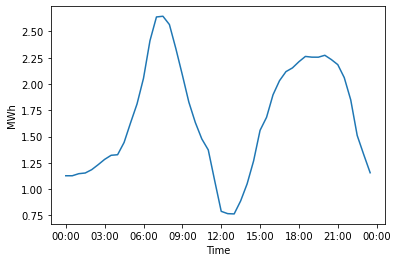

In [412]:
# calculate the net load (be careful with sign used in solar)
nondispatchable_net_load = load_profile - solar_profile

# plot graph
plt.plot(nondispatchable_net_load[a:b])
plt.ylabel("MWh")
plt.xlabel("Time")
plt.xticks(np.linspace(a, b, 9),['00:00','03:00','06:00','09:00','12:00','15:00','18:00','21:00','00:00'])
plt.show()


In [413]:
nondispatchable_net_load = nondispatchable_net_load.Power

In [414]:
energy_capacity = 20                          # MWh
power_capacity = 7.5                              # MW
eff = 0.7

T = len(nondispatchable_net_load)

outpute = np.zeros((T,1))
soce = np.zeros((T,1))

for j in range(0,T):
    if j == 0:
        socval = energy_capacity
    else:
        socval = soce[j-1]

    if nondispatchable_net_load[j] > 0: 
        outpute[j] = min(power_capacity*0.5, nondispatchable_net_load[j], eff*socval)
        soce[j] = socval - (1/eff)*outpute[j]
        
    elif nondispatchable_net_load[j] < 0: 
        outpute[j] = max(-power_capacity*0.5, nondispatchable_net_load[j],
              -(1/eff)*(energy_capacity - socval))
        soce[j] = socval - eff*outpute[j]
        
    elif nondispatchable_net_load[j] == 0: 
        soce[j] = socval

m = np.array(nondispatchable_net_load).reshape(-1,1)

# calculate final system net load
net_loade = m - outpute

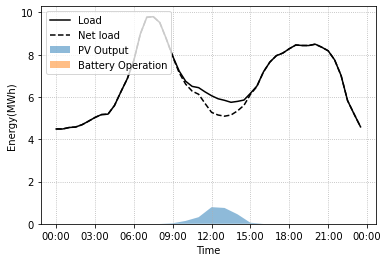

In [407]:
labels = ['PV Output', 'Battery Operation']

ax = plt.subplot(1,1,1)
ax.grid(True,linestyle='dotted')


p1 = plt.stackplot(np.arange(a,b),solar_profile[a:b].T, outpute[a:b].T, labels=labels, alpha=0.5)

p2 = plt.plot(load_profile[a:b], '-k', label='Load')

p3 = plt.plot(np.arange(a,b),net_loade[a:b], '--k', label='Net load')

plt.xticks(np.linspace(a, b, 9),['00:00','03:00','06:00','09:00','12:00','15:00','18:00','21:00','00:00'])

plt.ylabel('Energy(MWh)', color='k')
plt.xlabel('Time', color='k')

ax.legend(loc='upper left')
plt.show()

In [398]:
net_loade[a:b]

array([[ 2.30675899],
       [ 2.41466344],
       [ 2.45676534],
       [ 2.39845729],
       [ 2.38243397],
       [ 2.4123737 ],
       [ 2.4081253 ],
       [ 2.33666508],
       [ 2.38740979],
       [ 2.30651446],
       [ 2.40290415],
       [ 2.29152564],
       [ 2.16129589],
       [ 1.37711949],
       [ 0.40050766],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [-0.34858824],
       [-0.92752991],
       [-1.22513795],
       [-1.41276816],
       [-1.38297769],
       [-3.46178312],
       [-4.34689867],
       [-3.46725468],
       [-2.55134564],
       [-1.49983668],
       [-0.77407177],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 3.45794523],
       [ 4.17935375],
       [ 4.26818634],
       [ 4.28320893],
       [ 4.40022702],
       [ 4.31068895],
       [ 4.20982881],
       [ 3.88681375],
       [ 3.44143354],
       [ 2

In [399]:
# separate import and export. Cross check annual net load.
annual_import = nondispatchable_net_load[nondispatchable_net_load>0].sum()
annual_export = nondispatchable_net_load[nondispatchable_net_load<0].sum()
annual_net =  annual_import + annual_export
print("Annual energy {:.2f} MWh".format(annual_net))

# costs with import at 15p/kWh and export at 5p/kWh
import_rate = 0.15
export_rate = 0.05
annual_cost = (annual_import * import_rate*1000) + (annual_export * export_rate*1000)
print("Annual cost £{:.2f}".format(annual_cost))

Annual energy 62623.07 MWh
Annual cost £10099445.81


In [341]:
print("With no battery")
print("Annual energy {:.2f} MWh".format(annual_net))
print("Annual cost £{:.2f}".format(annual_cost))

With no battery
Annual energy 62623.07 MWh
Annual cost £10099445.81


In [342]:
print("With Practical Battery")
annual_import = net_loade[net_loade>0].sum()
annual_export = net_loade[net_loade<0].sum()
annual_net_e =  annual_import + annual_export
print("Annual energy {:.2f} MWh".format(annual_net_e))

# costs with import at 15p/kWh and export at 5p/kWh
annual_cost_e = (annual_import * 0.15*1000) + (annual_export * 0.05*1000)
print("Annual cost £{:.2f}".format(annual_cost_e))

print("A saving of £{:.2f}".format(annual_cost-annual_cost_e))

With Practical Battery
Annual energy 64164.52 MWh
Annual cost £10026634.08
A saving of £72811.73
